# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print X_train.shape

(49000, 32, 32, 3)


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=False)
print X_train_feats.shape
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

(49000, 154)


In [4]:
# 1. Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

In [5]:
pass
'''
# test. Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat_dim = np.std(X_train_feats, axis=0, keepdims=True)
std_feat_max_hog = np.max(std_feat_dim[0,0:144])
std_feat_max_hsv = np.max(std_feat_dim[0,144:])
print std_feat_max_hog
print std_feat_max_hsv
std_feat= np.copy(std_feat_dim)
std_feat[0,0:144] = std_feat_max_hog
std_feat[0,144:]  = std_feat_max_hsv
print std_feat.shape
'''
'''
# 2. Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
std_feat_max_hog = np.max(std_feat)
print std_feat_max_hog
print std_feat
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat
'''

'\n# 2. Preprocessing: Divide by standard deviation. This ensures that each feature\n# has roughly the same scale.\nstd_feat = np.std(X_train_feats, axis=0, keepdims=True)\nstd_feat_max_hog = np.max(std_feat)\nprint std_feat_max_hog\nprint std_feat\nX_train_feats /= std_feat\nX_val_feats /= std_feat\nX_test_feats /= std_feat\n'

In [6]:
# 3. Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [5e-7, 8e-7]
regularization_strengths = [1e5, 2e5]
num_iters=800

results = {}
best_val = -1
best_svm = None
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# pass
for lr in learning_rates :
    for reg in regularization_strengths :
        svm = LinearSVM()
        # tic = time.time()
        loss_hist = svm.train(X_train_feats, y_train, lr, reg, num_iters)  
        
        y_train_pred   = svm.predict(X_train_feats)
        y_val_pred     = svm.predict(X_val_feats)
        train_accuracy = np.mean(y_train == y_train_pred) 
        val_accuracy   = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        
        if best_val < val_accuracy :
            best_val = val_accuracy
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 5.000000e-07 reg 1.000000e+05 train accuracy: 0.381673 val accuracy: 0.380000
lr 5.000000e-07 reg 2.000000e+05 train accuracy: 0.361245 val accuracy: 0.362000
lr 8.000000e-07 reg 1.000000e+05 train accuracy: 0.387469 val accuracy: 0.390000
lr 8.000000e-07 reg 2.000000e+05 train accuracy: 0.105429 val accuracy: 0.090000
best validation accuracy achieved during cross-validation: 0.390000


In [8]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.377


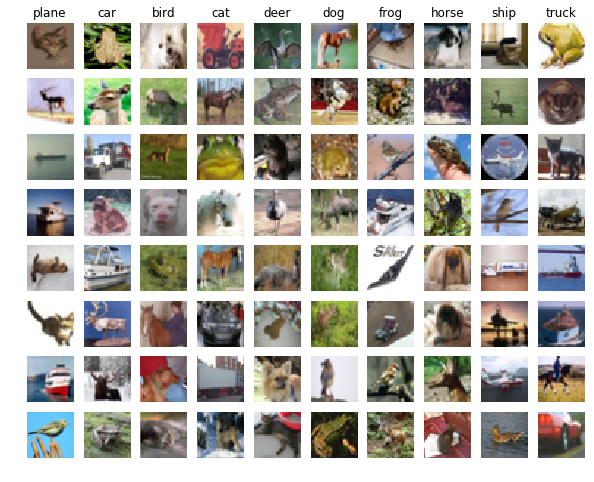

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if idxs.size :
        idxs = np.random.choice(idxs, examples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
            plt.imshow(X_test[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?  

my question: what is HOG and Color Histogram hue channel in HSV color space?  
my answer: should be argueable by the property of the feature. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
print X_train_feats.shape

(49000, 155)


input_dim= 155
validation accuracy = 0.105000 , net (hs = 500, reg = 2.900e-03, lr = 1.345e-04, bs = 200, lr_decay = 9.50e-01)


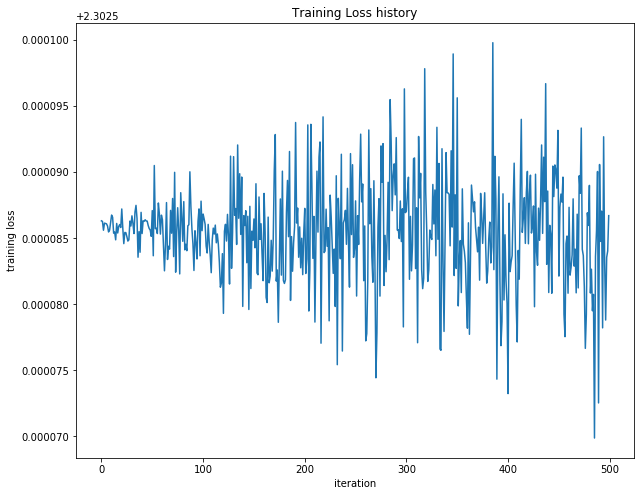

validation accuracy = 0.087000 , net (hs = 500, reg = 6.288e-01, lr = 1.344e-04, bs = 200, lr_decay = 9.50e-01)


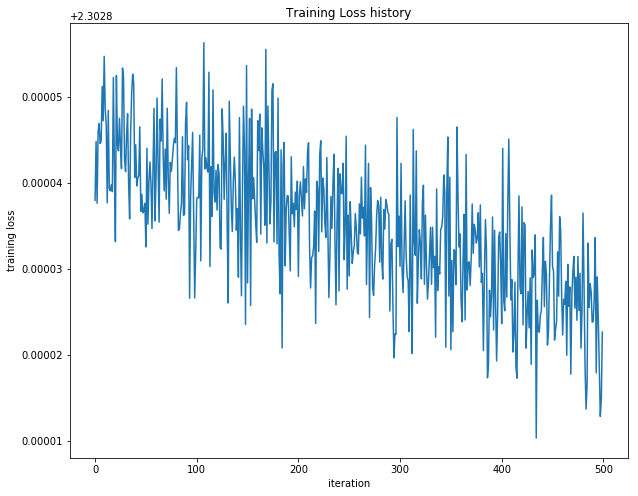

validation accuracy = 0.078000 , net (hs = 500, reg = 3.733e-04, lr = 4.240e-04, bs = 200, lr_decay = 9.50e-01)


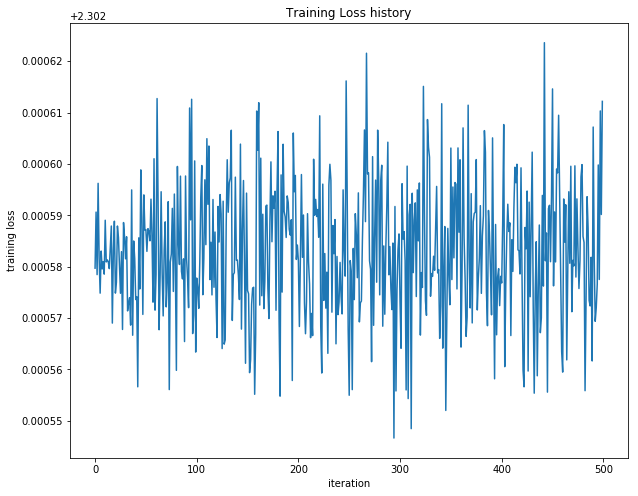

In [11]:
from cs231n.classifiers.neural_net import TwoLayerNet
import random

input_dim = X_train_feats.shape[1]
print 'input_dim= %d' % input_dim
hidden_dim = [500]
num_classes = 10

results = {}
best_val = -1
best_stats = None
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

batch_size = [200] #[100, 200] # 
learning_rate_decay = [0.95] # [0.95] # 
max_count = 3
num_iters = 500

for hs in hidden_dim :
    # create the net
    net = TwoLayerNet(input_dim, hs, num_classes)
    
    for bs in batch_size:
        for lr_decay in learning_rate_decay:
            
            for count in xrange(max_count) :
                reg = 10**random.uniform(-5,  5)
                lr  = 10**random.uniform(-3, -6)
            
                # Train the network
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val, 
                                  lr, lr_decay,reg, 
                                  num_iters, 
                                  bs, False)

                train_accuracy = stats['train_acc_history'][-1]
                val_accuracy   = stats['val_acc_history'][-1]
                results[(hs, reg, lr, bs, lr_decay)] = (train_accuracy, val_accuracy)
                print 'validation accuracy = %f , net (hs = %d, reg = %.3e, lr = %.3e, bs = %d, lr_decay = %.2e)' % (val_accuracy, hs, reg, lr, bs, lr_decay)

                # plot the loss history
                plt.plot(stats['loss_history'])
                plt.xlabel('iteration')
                plt.ylabel('training loss')
                plt.title('Training Loss history')
                plt.show()
                
                if val_accuracy > best_val :
                    best_stats = stats
                    best_val = val_accuracy
                    best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [12]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print test_acc

0.09


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

In [13]:
%load_ext version_information

%version_information numpy, scipy, matplotlib, sympy

Software versions
Python 2.7.13 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.1.0
OS Linux 4.7.0 040700rc2 generic x86_64 with debian stretch sid
numpy 1.11.3
scipy 0.18.1
matplotlib 2.0.0
sympy 1.0
Mon Apr 17 10:23:26 2017 CEST